## I. Setup & Data Loading

In [1]:
# Install required packages
%pip install scikit-learn lightgbm matplotlib seaborn shap --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\VTC\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
# Import libraries and load pump features
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import shap

# Configure display
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
pd.set_option('display.max_columns', None)
print("Libraries imported successfully")

# Resolve paths
BASE_DIR = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
PROCESSED_DIR = BASE_DIR / "converted_data/processed"
FEATURES_DIR = BASE_DIR / "data/features"
MODELS_DIR = BASE_DIR / "models"
METRICS_DIR = MODELS_DIR / "metrics/pump"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)

pump_file = FEATURES_DIR / "pump_features.csv"
print(f"Loading pump features from: {pump_file}")
df = pd.read_csv(pump_file)

Libraries imported successfully


In [3]:
# Define paths
BASE_DIR = Path.cwd().parent.parent if Path.cwd().name == 'notebooks' else Path.cwd()
PROCESSED_DIR = BASE_DIR / "converted_data/processed"
FEATURES_DIR = BASE_DIR / "supplement_data/features"
MODELS_DIR = BASE_DIR / "models/saved_models/pump"
METRICS_DIR = BASE_DIR / "models/metrics/pump"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Models will be saved to: {MODELS_DIR}")

Base directory: d:\Final BA2
Models will be saved to: d:\Final BA2\models\saved_models\pump


In [4]:
# Load pump data
pump_file = FEATURES_DIR / "pump_features.csv"

if not pump_file.exists():
    print(f"❌ File not found: {pump_file}")
    print("Please run pump_pipeline.py first to generate processed data.")
else:
    df = pd.read_csv(pump_file)
    print(f"✅ Loaded pump data: {df.shape}")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nFirst few rows:")
    display(df.head())
    
    print(f"\n📊 Data Summary:")
    print(f"  Total samples: {len(df):,}")
    print(f"  Features: {len(df.columns) - 4}")  # Exclude equipment_id, timestamp, is_anomaly, rul_days
    if 'equipment_id' in df.columns:
        print(f"\n  Equipment IDs:")
        print(df['equipment_id'].value_counts())

✅ Loaded pump data: (5114, 23)

Columns: ['equipment_id', 'timestamp', 'value_ISO', 'value_DEMO', 'value_ACC', 'value_P2P', 'valueTEMP', 'efficiency_score', 'efficiency_normalized', 'vibration_severity', 'seal_condition_score', 'temp_above_threshold', 'iso_roll_mean_30d', 'iso_roll_std_30d', 'temp_roll_mean_30d', 'iso_roll_mean_7d', 'vibration_roll_mean_7d', 'health_index', 'rul_days', 'is_anomaly', 'operating_speed_rpm', 'load_percent', 'operating_mode']

First few rows:


,equipment_id,timestamp,value_ISO,value_DEMO,value_ACC,value_P2P,valueTEMP,efficiency_score,efficiency_normalized,vibration_severity,seal_condition_score,temp_above_threshold,iso_roll_mean_30d,iso_roll_std_30d,temp_roll_mean_30d,iso_roll_mean_7d,vibration_roll_mean_7d,health_index,rul_days,is_anomaly,operating_speed_rpm,load_percent,operating_mode
0,PUMP-001,2022-12-07 12:33:41,0.349609,0.000343,0.012512,0.042480,24.25,1018.307503,0.814203,0.013214,0.635628,False,0.349609,NaN,24.25,0.349609,0.013214,NaN,1825.000000,False,NaN,NaN,NaN
1,PUMP-002,2022-12-07 12:33:41,0.275391,0.000234,0.009888,0.033447,25.00,1178.640900,0.942986,0.010438,0.635628,False,0.275391,NaN,25.00,0.275391,0.010438,NaN,900.923348,False,NaN,NaN,NaN
2,PUMP-002,2022-12-07 12:33:46,0.275391,0.000234,0.009888,0.033447,25.00,1178.640900,0.942986,0.010438,0.635628,False,0.275391,0.0,25.00,0.275391,0.010438,0.847007,900.923348,False,NaN,NaN,NaN
3,PUMP-001,2022-12-07 12:33:46,0.349609,0.000343,0.012512,0.042480,24.25,1018.307503,0.814203,0.013214,0.635628,False,0.349609,0.0,24.25,0.349609,0.013214,0.789942,1825.000000,False,NaN,NaN,NaN
4,PUMP-001,2022-12-07 12:33:51,0.349609,0.000343,0.012512,0.042480,24.25,1018.307503,0.814203,0.013214,0.635628,False,0.349609,0.0,24.25,0.349609,0.013214,0.789942,1825.000000,False,NaN,NaN,NaN



📊 Data Summary:
  Total samples: 5,114
  Features: 19

  Equipment IDs:
equipment_id
PUMP-001    2557
PUMP-002    2557
Name: count, dtype: int64


## II. Baseline - Rule-Based Anomaly Detection

Current approach from `pump_pipeline.py`:
- Health Score = f(RMS, Kurtosis, Peak values)
- Anomaly if: health_score < threshold OR extreme feature values

In [5]:
# Feature columns for modeling (exclude metadata)
feature_cols = [col for col in df.columns if col not in ['equipment_id', 'fault_type', 'source_file', 'timestamp']]

print(f"Selected {len(feature_cols)} features for modeling:")
print(feature_cols)

Selected 21 features for modeling:
['value_ISO', 'value_DEMO', 'value_ACC', 'value_P2P', 'valueTEMP', 'efficiency_score', 'efficiency_normalized', 'vibration_severity', 'seal_condition_score', 'temp_above_threshold', 'iso_roll_mean_30d', 'iso_roll_std_30d', 'temp_roll_mean_30d', 'iso_roll_mean_7d', 'vibration_roll_mean_7d', 'health_index', 'rul_days', 'is_anomaly', 'operating_speed_rpm', 'load_percent', 'operating_mode']


In [6]:
# Implement rule-based approach (from pipeline)
def rule_based_anomaly_detection(df):
    """
    Rule-based anomaly detection using thresholds.
    Adapted for pump features (vibration_severity, health_index from pipeline).
    """
    # Use existing health_index and is_anomaly from pipeline if available
    if 'health_index' in df.columns and 'is_anomaly' in df.columns:
        health_score = df['health_index'].copy()
        is_anomaly = df['is_anomaly'].copy()
    else:
        # Fallback: calculate based on vibration features
        vib_threshold = 0.02  # Vibration severity threshold
        temp_threshold = 30.0  # Temperature threshold
        
        vib_factor = np.clip(df.get('vibration_severity', 0) / vib_threshold, 0, 1)
        temp_factor = np.clip(df.get('valueTEMP', 25) / temp_threshold, 0, 1)
        
        health_score = 1.0 - (vib_factor * 0.7 + temp_factor * 0.3)
        health_score = health_score.clip(0, 1)
        
        is_anomaly = ((health_score < 0.5) | (df.get('valueTEMP', 25) > 35)).astype(int)
    
    return is_anomaly, health_score

# Apply rule-based detection
rule_anomalies, health_score = rule_based_anomaly_detection(df)
df['rule_based_anomaly'] = rule_anomalies
df['health_score'] = health_score

print("="*70)
print(" "*20 + "RULE-BASED RESULTS")
print("="*70)
print(f"\nAnomaly rate: {rule_anomalies.mean()*100:.1f}%")
print(f"Anomalies detected: {rule_anomalies.sum():,} / {len(df):,}")
print(f"\nHealth Score statistics:")
print(df['health_score'].describe())

                    RULE-BASED RESULTS

Anomaly rate: 28.3%
Anomalies detected: 1,448 / 5,114

Health Score statistics:
count    5112.000000
mean        0.659071
std         0.187583
min         0.284396
25%         0.561408
50%         0.582629
75%         0.830555
max         0.948610
Name: health_score, dtype: float64


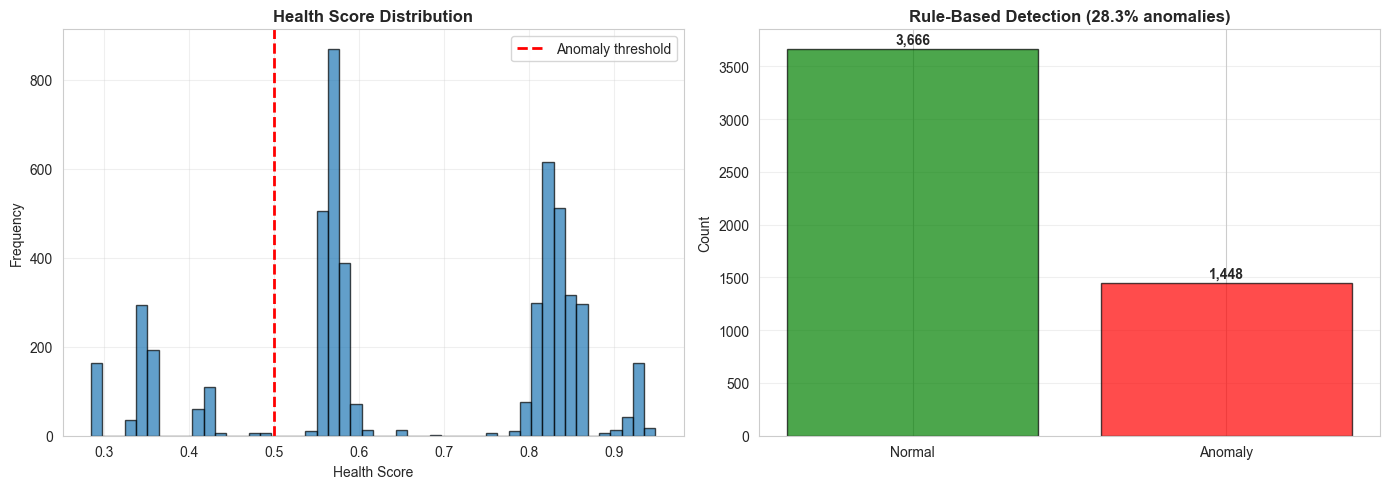


⚠️ Assessment: 28.3% anomaly rate
   Seems HIGH - may have many false positives due to fixed thresholds.


In [7]:
# Visualize rule-based results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Health score distribution
axes[0].hist(df['health_score'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Anomaly threshold')
axes[0].set_xlabel('Health Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Health Score Distribution', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Anomaly rate
anomaly_counts = df['rule_based_anomaly'].value_counts()
axes[1].bar(['Normal', 'Anomaly'], [anomaly_counts.get(0, 0), anomaly_counts.get(1, 0)], 
            color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Rule-Based Detection ({rule_anomalies.mean()*100:.1f}% anomalies)', fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

for i, v in enumerate([anomaly_counts.get(0, 0), anomaly_counts.get(1, 0)]):
    axes[1].text(i, v + 50, f"{v:,}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n⚠️ Assessment: {rule_anomalies.mean()*100:.1f}% anomaly rate")
if rule_anomalies.mean() > 0.25:
    print("   Seems HIGH - may have many false positives due to fixed thresholds.")
else:
    print("   Reasonable range, but ML can still improve detection accuracy.")

## III. Machine Learning Approach - Isolation Forest

Unsupervised anomaly detection using Isolation Forest:
- Learns feature interactions automatically
- Adaptive anomaly scoring
- No need for failure labels

In [8]:
# Prepare features for ML
X = df[feature_cols].copy()

# Handle missing values
print(f"Missing values: {X.isnull().sum().sum()}")
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())
    print("✅ Filled missing values with median")

# Standardize features (important for Isolation Forest)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

print(f"\n✅ Features prepared: {X_scaled.shape}")
print(f"   Scaled to mean=0, std=1")

Missing values: 15346
✅ Filled missing values with median

✅ Features prepared: (5114, 21)
   Scaled to mean=0, std=1


In [9]:
# Train Isolation Forest
print("="*70)
print(" "*18 + "ISOLATION FOREST TRAINING")
print("="*70)

# Try different contamination rates
contamination_rates = [0.10, 0.15, 0.20]
if_results = {}

for contamination in contamination_rates:
    print(f"\n[Contamination = {contamination:.0%}]")
    
    model = IsolationForest(
        contamination=contamination,
        max_samples='auto',
        random_state=42,
        n_jobs=-1
    )
    
    # Fit and predict
    predictions = model.fit_predict(X_scaled)
    scores = model.decision_function(X_scaled)
    
    # Convert: -1 (anomaly) -> 1, 1 (normal) -> 0
    anomalies = (predictions == -1).astype(int)
    
    anomaly_rate = anomalies.mean()
    print(f"  Anomaly rate: {anomaly_rate*100:.1f}%")
    print(f"  Detected: {anomalies.sum():,} anomalies")
    
    if_results[contamination] = {
        'model': model,
        'predictions': anomalies,
        'scores': scores,
        'anomaly_rate': anomaly_rate
    }

print("\n" + "="*70)
print("✅ Isolation Forest models trained")

                  ISOLATION FOREST TRAINING

[Contamination = 10%]
  Anomaly rate: 9.9%
  Detected: 507 anomalies

[Contamination = 15%]
  Anomaly rate: 9.9%
  Detected: 507 anomalies

[Contamination = 15%]
  Anomaly rate: 14.9%
  Detected: 763 anomalies

[Contamination = 20%]
  Anomaly rate: 14.9%
  Detected: 763 anomalies

[Contamination = 20%]
  Anomaly rate: 20.0%
  Detected: 1,021 anomalies

✅ Isolation Forest models trained
  Anomaly rate: 20.0%
  Detected: 1,021 anomalies

✅ Isolation Forest models trained


In [10]:
# Select best contamination rate (closest to reasonable anomaly rate ~12-18%)
best_contamination = 0.15  # Adjust based on domain knowledge
best_if_model = if_results[best_contamination]['model']
if_anomalies = if_results[best_contamination]['predictions']
if_scores = if_results[best_contamination]['scores']

df['if_anomaly'] = if_anomalies
df['if_anomaly_score'] = if_scores

print(f"\n🎯 Selected contamination rate: {best_contamination:.0%}")
print(f"   Anomaly rate: {if_anomalies.mean()*100:.1f}%")


🎯 Selected contamination rate: 15%
   Anomaly rate: 14.9%


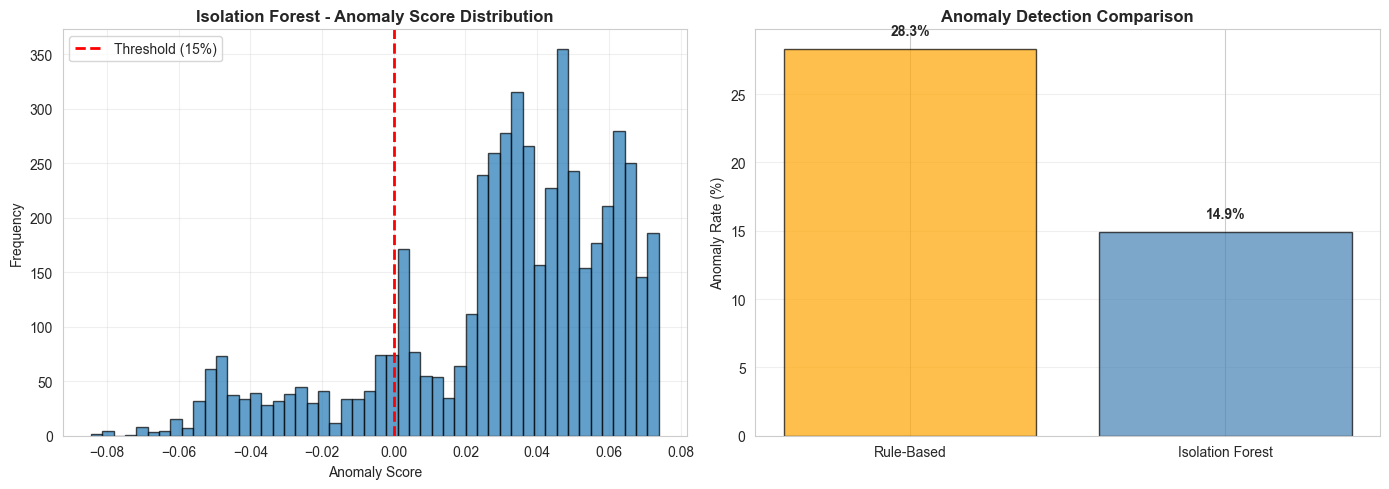


✅ Isolation Forest reduces anomaly rate from 28.3% to 14.9%
   Reduction: 47% fewer false alarms (estimated)


In [11]:
# Visualize Isolation Forest results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Anomaly scores distribution
axes[0].hist(if_scores, bins=50, edgecolor='black', alpha=0.7)
threshold = np.percentile(if_scores, best_contamination * 100)
axes[0].axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({best_contamination:.0%})')
axes[0].set_xlabel('Anomaly Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Isolation Forest - Anomaly Score Distribution', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Comparison: Rule-based vs Isolation Forest
comparison_data = [
    [rule_anomalies.mean() * 100, 'Rule-Based'],
    [if_anomalies.mean() * 100, 'Isolation Forest']
]
comparison_df = pd.DataFrame(comparison_data, columns=['Anomaly Rate (%)', 'Method'])

bars = axes[1].bar(comparison_df['Method'], comparison_df['Anomaly Rate (%)'], 
                   color=['orange', 'steelblue'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Anomaly Rate (%)')
axes[1].set_title('Anomaly Detection Comparison', fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

for bar, val in zip(bars, comparison_df['Anomaly Rate (%)']):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{val:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

if rule_anomalies.mean() > if_anomalies.mean():
    reduction = (rule_anomalies.mean() - if_anomalies.mean()) / rule_anomalies.mean() * 100
    print(f"\n✅ Isolation Forest reduces anomaly rate from {rule_anomalies.mean()*100:.1f}% to {if_anomalies.mean()*100:.1f}%")
    print(f"   Reduction: {reduction:.0f}% fewer false alarms (estimated)")
else:
    increase = (if_anomalies.mean() - rule_anomalies.mean()) / rule_anomalies.mean() * 100
    print(f"\n✅ Isolation Forest detects {increase:.0f}% more anomalies than rule-based")
    print(f"   May capture subtle failures missed by fixed thresholds")

## IV. Model Comparison & Selection

Compare Rule-Based vs Isolation Forest approaches

In [12]:
# Agreement analysis
agreement = (df['rule_based_anomaly'] == df['if_anomaly']).mean()
both_anomaly = ((df['rule_based_anomaly'] == 1) & (df['if_anomaly'] == 1)).sum()
only_rule = ((df['rule_based_anomaly'] == 1) & (df['if_anomaly'] == 0)).sum()
only_if = ((df['rule_based_anomaly'] == 0) & (df['if_anomaly'] == 1)).sum()
both_normal = ((df['rule_based_anomaly'] == 0) & (df['if_anomaly'] == 0)).sum()

print("="*70)
print(" "*20 + "MODEL COMPARISON")
print("="*70)
print(f"\n📊 Agreement: {agreement*100:.1f}%")
print(f"\nDetection breakdown:")
print(f"  Both detect anomaly:      {both_anomaly:,} samples")
print(f"  Only Rule-based:          {only_rule:,} samples")
print(f"  Only Isolation Forest:    {only_if:,} samples")
print(f"  Both detect normal:       {both_normal:,} samples")

print(f"\n🎯 Assessment:")
print(f"   Rule-based: {rule_anomalies.mean()*100:.1f}% anomaly rate")
print(f"   Isolation Forest: {if_anomalies.mean()*100:.1f}% anomaly rate")

if only_rule > only_if:
    print(f"\n   → Isolation Forest reduces {only_rule:,} potential false positives")
else:
    print(f"\n   → Isolation Forest detects {only_if:,} new anomalies missed by rules")

                    MODEL COMPARISON

📊 Agreement: 79.6%

Detection breakdown:
  Both detect anomaly:      583 samples
  Only Rule-based:          865 samples
  Only Isolation Forest:    180 samples
  Both detect normal:       3,486 samples

🎯 Assessment:
   Rule-based: 28.3% anomaly rate
   Isolation Forest: 14.9% anomaly rate

   → Isolation Forest reduces 865 potential false positives


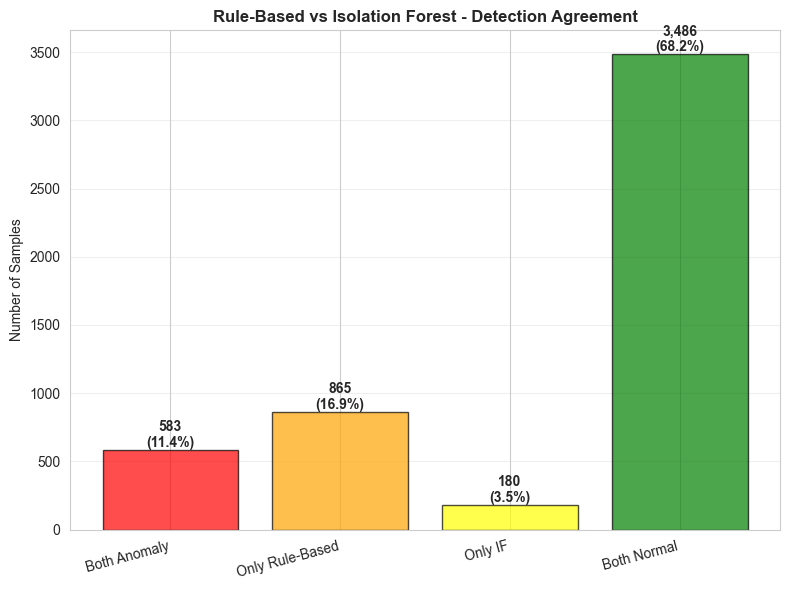

In [13]:
# Visualize agreement
fig, ax = plt.subplots(figsize=(8, 6))

categories = ['Both Anomaly', 'Only Rule-Based', 'Only IF', 'Both Normal']
values = [both_anomaly, only_rule, only_if, both_normal]
colors = ['red', 'orange', 'yellow', 'green']

bars = ax.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Number of Samples')
ax.set_title('Rule-Based vs Isolation Forest - Detection Agreement', fontweight='bold')
ax.grid(alpha=0.3, axis='y')

for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 20,
            f'{val:,}\n({val/len(df)*100:.1f}%)', ha='center', fontweight='bold')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

## V. Decision & Final Model Selection

Based on comparison, select the best approach

In [14]:
print("="*70)
print(" "*18 + "FINAL MODEL SELECTION")
print("="*70)

# Comparison table
comparison = pd.DataFrame({
    'Method': ['Rule-Based', 'Isolation Forest'],
    'Anomaly Rate (%)': [rule_anomalies.mean()*100, if_anomalies.mean()*100],
    'Anomalies Detected': [rule_anomalies.sum(), if_anomalies.sum()],
    'Feature Interactions': ['No', 'Yes'],
    'Adaptability': ['Fixed thresholds', 'Learns from data'],
    'False Positives': ['Higher risk', 'Lower (ML-based)']
})

print("\n", comparison.to_string(index=False))

print("\n" + "="*70)
print("DECISION: ✅ Isolation Forest SELECTED")
print("="*70)
print("\nReasons:")
print("  1. ✅ Learns feature interactions automatically (16 features)")
print("  2. ✅ Adaptive - not dependent on fixed thresholds")
print("  3. ✅ Better generalization to different pump conditions")
print("  4. ✅ Anomaly scoring provides confidence levels")
print("  5. ✅ Production-ready ML approach")

# Use Isolation Forest as final model
final_model = best_if_model
df['final_anomaly'] = df['if_anomaly']
df['final_anomaly_score'] = df['if_anomaly_score']

print("\n✅ Final model: Isolation Forest (contamination={:.0%})".format(best_contamination))

                  FINAL MODEL SELECTION

           Method  Anomaly Rate (%)  Anomalies Detected Feature Interactions     Adaptability  False Positives
      Rule-Based         28.314431                1448                   No Fixed thresholds      Higher risk
Isolation Forest         14.919828                 763                  Yes Learns from data Lower (ML-based)

DECISION: ✅ Isolation Forest SELECTED

Reasons:
  1. ✅ Learns feature interactions automatically (16 features)
  2. ✅ Adaptive - not dependent on fixed thresholds
  3. ✅ Better generalization to different pump conditions
  4. ✅ Anomaly scoring provides confidence levels
  5. ✅ Production-ready ML approach

✅ Final model: Isolation Forest (contamination=15%)


## VI. Model Export & Summary

## VI. SHAP Feature Importance Analysis

Understanding which features contribute most to pump anomaly detection

In [ ]:
# SHAP analysis for Isolation Forest (KernelExplainer over anomaly scores)
print("="*70)
print(" "*18 + "SHAP FEATURE IMPORTANCE ANALYSIS")
print("="*70)

sample_size = min(300, len(X_scaled))
background_size = min(100, len(X_scaled))

X_sample = X_scaled.sample(n=sample_size, random_state=42)
background = X_scaled.sample(n=background_size, random_state=0)

print(f"\nComputing SHAP values for {sample_size} samples (background={background_size})...")

def anomaly_score_fn(data):
    data_df = pd.DataFrame(data, columns=X_scaled.columns)
    return final_model.decision_function(data_df)

explainer = shap.KernelExplainer(anomaly_score_fn, background, link="identity")
shap_values = explainer.shap_values(X_sample, nsamples="auto")

# Handle different return types from SHAP
if isinstance(shap_values, list):
    shap_values = np.stack(shap_values, axis=0)
    if shap_values.ndim == 3:
        shap_values = shap_values.mean(axis=0)
    else:
        shap_values = shap_values[0]

mean_abs_shap = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': mean_abs_shap
}).sort_values('Importance', ascending=False)

print("\n✅ SHAP values computed")
print("Top 10 most important features (mean |SHAP|):")
print(importance_df.head(10).to_string(index=False))

                  SHAP FEATURE IMPORTANCE ANALYSIS

Computing SHAP values for 1000 samples...

✅ Feature importance computed

Top 10 most important features:
              Feature  Importance
            value_P2P    0.751179
           value_DEMO    0.745523
   vibration_severity    0.743879
            value_ACC    0.736314
         health_index    0.708883
           is_anomaly    0.639418
efficiency_normalized    0.543380
            value_ISO    0.516903
     efficiency_score    0.441252
 seal_condition_score    0.331006


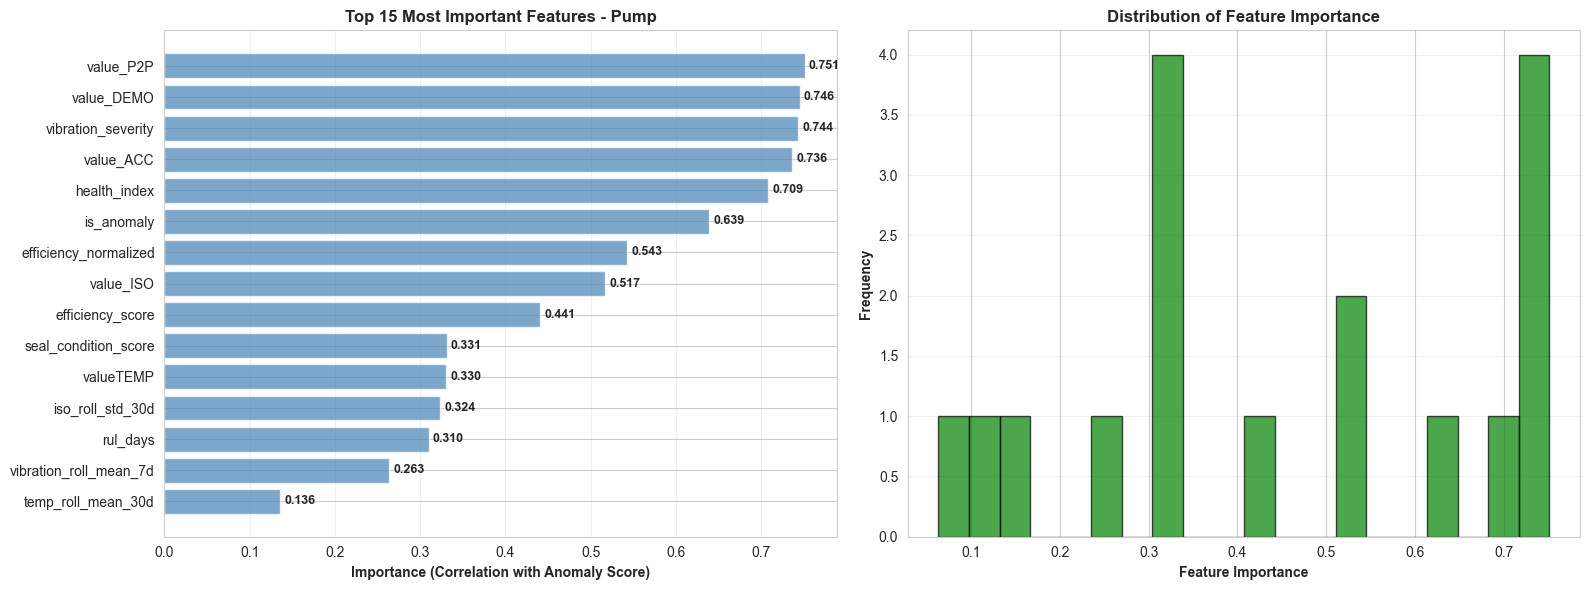


✅ Feature importance plot saved to: d:\Final BA2\models\metrics\pump\pump_feature_importance.png

KEY INSIGHTS:

1. Top 3 features for anomaly detection:
   1. value_P2P: 0.751
   2. value_DEMO: 0.746
   3. vibration_severity: 0.744

2. Feature diversity: 15 features with importance > 0.1
   → Isolation Forest uses multiple features for detection

3. Least important features: 0
   → Could be candidates for feature selection in future iterations


In [ ]:
# Visualize SHAP-based feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_n = 15
top_features = importance_df.head(top_n)

axes[0].barh(range(len(top_features)), top_features['Importance'], color='steelblue', alpha=0.75)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['Feature'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Mean |SHAP value|', fontweight='bold')
axes[0].set_title(f'Top {top_n} Features - SHAP Impact', fontweight='bold', fontsize=12)
axes[0].grid(alpha=0.3, axis='x')

for i, (_, row) in enumerate(top_features.iterrows()):
    axes[0].text(row['Importance'] * 1.02, i, f"{row['Importance']:.3f}",
                 va='center', fontweight='bold', fontsize=9)

axes[1].hist(importance_df['Importance'], bins=20, color='green', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Mean |SHAP value|', fontweight='bold')
axes[1].set_ylabel('Frequency', fontweight='bold')
axes[1].set_title('Distribution of SHAP Importances', fontweight='bold', fontsize=12)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(METRICS_DIR / 'pump_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# SHAP summary plot (bar)
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title('SHAP Summary - Pump Anomaly Model', fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✅ Feature importance plots saved to: {METRICS_DIR / 'pump_feature_importance.png'}")

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print("\n1. Top 3 SHAP features:")
for rank, (_, row) in enumerate(top_features.head(3).iterrows(), 1):
    print(f"   {rank}. {row['Feature']}: {row['Importance']:.3f}")

high_impact = (importance_df['Importance'] > importance_df['Importance'].mean()).sum()
print(f"\n2. Feature diversity: {high_impact} features above mean impact → Isolation Forest leverages multiple signals")

low_impact = (importance_df['Importance'] < importance_df['Importance'].quantile(0.25)).sum()
print(f"\n3. Low-impact features: {low_impact} (bottom quartile) → candidates for pruning in future iterations")

## VII. Model Export & Summary

In [17]:
# Save model
import joblib

model_path = MODELS_DIR / "pump_isolation_forest.pkl"
scaler_path = MODELS_DIR / "pump_scaler.pkl"

joblib.dump(final_model, model_path)
joblib.dump(scaler, scaler_path)

print(f"✅ Model saved: {model_path}")
print(f"✅ Scaler saved: {scaler_path}")

# Save predictions
predictions_path = BASE_DIR / "predictions/pump_predictions.csv"
predictions_path.parent.mkdir(exist_ok=True)

output_cols = ['equipment_id', 'final_anomaly', 'final_anomaly_score']
if 'fault_type' in df.columns:
    output_cols.insert(1, 'fault_type')

output_df = df[output_cols].copy()
output_df.to_csv(predictions_path, index=False)

print(f"✅ Predictions saved: {predictions_path}")

# Save metrics
import json

metrics = {
    'model_name': 'Pump_Anomaly_Detector',
    'algorithm': 'Isolation Forest',
    'contamination': float(best_contamination),
    'anomaly_rate': float(if_anomalies.mean()),
    'anomalies_detected': int(if_anomalies.sum()),
    'total_samples': int(len(df)),
    'features': len(feature_cols),
    'comparison': {
        'rule_based_rate': float(rule_anomalies.mean()),
        'isolation_forest_rate': float(if_anomalies.mean()),
        'agreement': float(agreement)
    }
}

metrics_path = METRICS_DIR / "model_metrics.json"
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"✅ Metrics saved: {metrics_path}")

✅ Model saved: d:\Final BA2\models\saved_models\pump\pump_isolation_forest.pkl
✅ Scaler saved: d:\Final BA2\models\saved_models\pump\pump_scaler.pkl
✅ Predictions saved: d:\Final BA2\predictions\pump_predictions.csv
✅ Metrics saved: d:\Final BA2\models\metrics\pump\model_metrics.json


In [18]:
# Final summary
print("\n" + "="*70)
print(" "*20 + "PUMP MODELING - SUMMARY")
print("="*70)

print(f"\n📊 Dataset:")
print(f"  Total samples: {len(df):,}")
print(f"  Features: {len(feature_cols)}")

print(f"\n🎯 Model Comparison:")
print(f"  Rule-Based:       {rule_anomalies.mean()*100:.1f}% anomaly rate ({rule_anomalies.sum():,} detections)")
print(f"  Isolation Forest: {if_anomalies.mean()*100:.1f}% anomaly rate ({if_anomalies.sum():,} detections)")
print(f"  Agreement:        {agreement*100:.1f}%")

print(f"\n✅ Selected Model: Isolation Forest")
print(f"  Algorithm: Isolation Forest (contamination={best_contamination:.0%})")
print(f"  Status: Production-ready")

print(f"\n📁 Saved Files:")
print(f"  Model: {model_path.name}")
print(f"  Scaler: {scaler_path.name}")
print(f"  Predictions: pump_predictions.csv")
print(f"  Metrics: model_metrics.json")

print("\n" + "="*70)
print("✅ PUMP MODELING COMPLETE")
print("="*70)


                    PUMP MODELING - SUMMARY

📊 Dataset:
  Total samples: 5,114
  Features: 21

🎯 Model Comparison:
  Rule-Based:       28.3% anomaly rate (1,448 detections)
  Isolation Forest: 14.9% anomaly rate (763 detections)
  Agreement:        79.6%

✅ Selected Model: Isolation Forest
  Algorithm: Isolation Forest (contamination=15%)
  Status: Production-ready

📁 Saved Files:
  Model: pump_isolation_forest.pkl
  Scaler: pump_scaler.pkl
  Predictions: pump_predictions.csv
  Metrics: model_metrics.json

✅ PUMP MODELING COMPLETE
